# Chapter 9
Implementing (and exploring) concepts from Computer Age Statistical Inference. Email me on sid \dot ravi1 \at gmail.com if you find any mistakes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

In [2]:
import pymc3 as pm
import theano.tensor as tt
from theano import shared

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Section 9.1

In [2]:
data = pd.read_csv("https://web.stanford.edu/~hastie/CASI_files/DATA/insurance.txt", sep=' ')

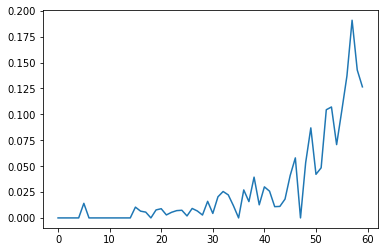

In [28]:
data['h_hat'] = data['y'] / data['n']
plt.plot(data['h_hat'])

$$ \hat{S}_{i,j} = \prod_{k=i}^{j} (1 - h_k)$$

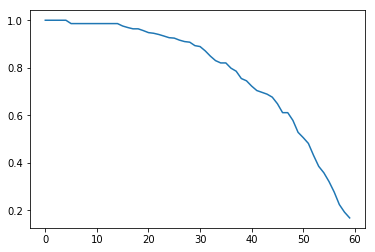

In [27]:
data['S_hat'] = (1 - data.h_hat).cumprod()
plt.plot(data['S_hat'])

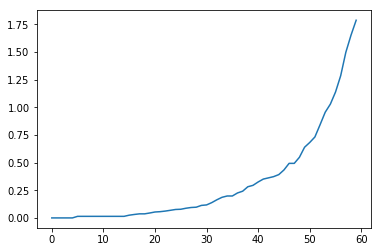

In [26]:
plt.plot(-data['S_hat'].apply(np.log))

## Section 9.2

In [422]:
data = pd.read_csv("https://web.stanford.edu/~hastie/CASI_files/DATA/ncog.txt", sep=" ")
armA = data[data.arm == 'A'].sort_values('t').reset_index(drop='True')
armB = data[data.arm == 'B'].sort_values('t').reset_index(drop='True')

### Table 9.1

In [412]:
armA_vals = armA.apply(lambda x: str(x['t']) + "+" if x['d'] == 0 else str(x['t']), axis=1).values
print(armA_vals)

['7' '34' '42' '63' '64' '74+' '83' '84' '91' '108' '112' '129' '133'
 '133' '139' '140' '140' '146' '149' '154' '157' '160' '160' '165' '173'
 '176' '185+' '218' '225' '241' '248' '273' '277' '279+' '297' '319+'
 '405' '417' '420' '440' '523' '523+' '583' '594' '1101' '1116+' '1146'
 '1226+' '1349+' '1412+' '1417']


In [413]:
armB_vals = armB.apply(lambda x: str(x['t']) + "+" if x['d'] == 0 else str(x['t']), axis=1).values
print(armB_vals)

['37' '84' '92' '94' '110' '112' '119' '127' '130' '133' '140' '146' '155'
 '159' '169+' '173' '179' '194' '195' '209' '249' '281' '319' '339' '432'
 '469' '519' '528+' '547+' '613+' '633' '725' '759+' '817' '1092+' '1245+'
 '1331+' '1557' '1642+' '1771+' '1776' '1897+' '2023+' '2146+' '2297+']


from: https://docs.pymc.io/notebooks/survival_analysis.html

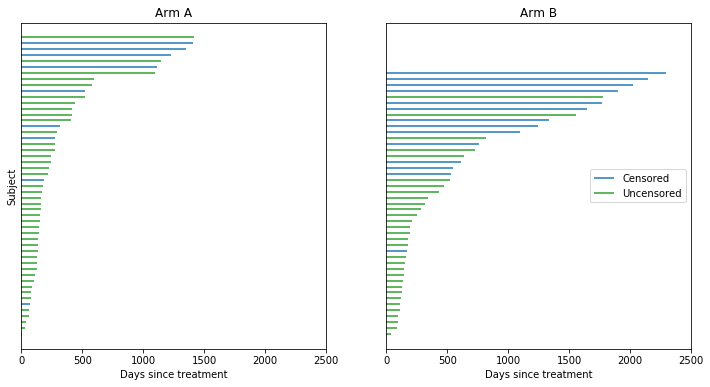

In [414]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)

blue, _, red = sns.color_palette()[:3]

n_patients_A = armA.shape[0]
patients = np.arange(n_patients_A)

ax.hlines(patients[armA.d.values == 0], 0, armA[armA.d.values == 0].t,
          color=blue, label='Censored')

ax.hlines(patients[armA.d.values == 1], 0, armA[armA.d.values == 1].t,
          color=red, label='Uncensored')

ax.set_title("Arm A")
ax.set_xlim(left=0)
ax.set_xlabel('Days since treatment')
ax.set_yticks([])
ax.set_ylabel('Subject')

n_patients_B = armB.shape[0]
patients = np.arange(n_patients_B)

ax2.hlines(patients[armB.d.values == 0], 0, armB[armB.d.values == 0].t,
          color=blue, label='Censored')

ax2.hlines(patients[armB.d.values == 1], 0, armB[armB.d.values == 1].t,
          color=red, label='Uncensored')

ax2.set_title("Arm B")
ax2.set_xlim(left=0)
ax2.set_xlabel('Days since treatment')
ax2.set_yticks([])

ax2.set_xlim(-0.25, armB.t.max() + 200)

ax2.legend(loc='center right');

In [1021]:
def make_survival_df(df):
    
    df['t_months'] = np.ceil(df.t / 30.5) # Yeah - took me a while to figure out how they created 'months'

    df_y = df.loc[df.d == 1].groupby('t_months')['day'].count()
    df_y.name = 'y'

    df_n = df.groupby('t_months')['day'].count()
    df_n = df_n.cumsum()
    df_n = df_n.max() - df_n.shift().fillna(0.0)
    df_n.name = 'n'

    index = pd.RangeIndex(start=1, stop=(df['t_months'].max() + 1))
    df_n = df_n.reindex(index).fillna(method='ffill')
    df_n = df_n.fillna(method='bfill')
    
    df_l = df.groupby('t_months')['d'].agg(lambda x: sum(1 - x))
    df_l.name = 'l'
    
    comb_df = pd.concat([df_n, df_y, df_l], axis=1).fillna(0.0)
    comb_df['h'] = comb_df['y'] / comb_df['n']
    comb_df['S_hat'] = (1 - comb_df.h).cumprod()
    
    comb_df.index.name = 'months'
    comb_df = comb_df.reset_index()

    comb_df['sd_S_hat'] = comb_df['S_hat'] * ((comb_df['y']/(comb_df['n']*(comb_df['n'] - comb_df['y']))).cumsum())**(1/2)
    
    #comb_df[r'$\hat{S}$'] = (1 - comb_df.h).cumprod()

    return comb_df

In [1024]:
armA_survival = make_survival_df(armA)
armB_survival = make_survival_df(armB)

### Table 9.3

In [1025]:
armB_survival.head()

,months,n,y,l,h,S_hat,sd_S_hat
0,1,45.0,0.0,0.0,0.000000,1.000000,0.000000
1,2,45.0,1.0,0.0,0.022222,0.977778,0.021974
2,3,44.0,1.0,0.0,0.022727,0.955556,0.030721
3,4,43.0,5.0,0.0,0.116279,0.844444,0.054028
4,5,38.0,5.0,0.0,0.131579,0.733333,0.065922


#### Plot Monthly data

(0, 47)

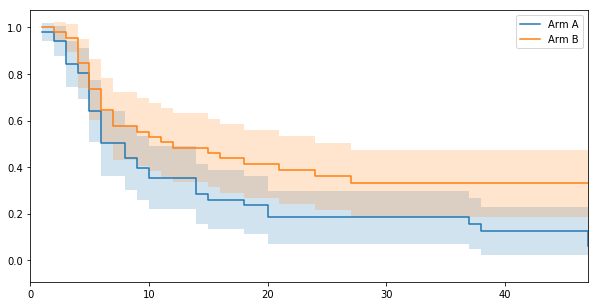

In [1026]:
plt.figure(figsize=(10,5))
plt.step(armA_survival.months, armA_survival.S_hat, where='post', label='Arm A',)
plt.step(armB_survival.months, armB_survival.S_hat, where='post', label='Arm B',)
plt.fill_between(armA_survival.months, armA_survival.S_hat + 1.96*armA_survival.sd_S_hat, armA_survival.S_hat - 1.96*armA_survival.sd_S_hat, alpha=0.2, step='post')
plt.fill_between(armB_survival.months, armB_survival.S_hat + 1.96*armB_survival.sd_S_hat, armB_survival.S_hat - 1.96*armB_survival.sd_S_hat, alpha=0.2, step='post')
plt.legend()
plt.xlim(0, 47)

### Figure 9.1

In [1027]:
armA['n'] = np.arange(len(armA), 0, -1)
armB['n'] = np.arange(len(armB), 0, -1)

In [1028]:
n_A = len(armA)
n_B = len(armB)

armA['X'] = armA.reset_index().apply(lambda x: ((n_A - x['index'])/ (n_A - x['index'] + 1))**(x['d']), axis=1)
armA['S_hat'] = armA['X'].cumprod()

armB['X'] = armB.reset_index().apply(lambda x: ((n_B - x['index'])/ (n_B - x['index'] + 1))**(x['d']), axis=1)
armB['S_hat'] = armB['X'].cumprod()

armA['sd_S_hat'] = armA['S_hat'] * ((armA['d']/(armA['n']*(armA['n'] - armA['d']))).cumsum())**(1/2)
armB['sd_S_hat'] = armB['S_hat'] * ((armB['d']/(armB['n']*(armB['n'] - armB['d']))).cumsum())**(1/2)

(0, 1440)

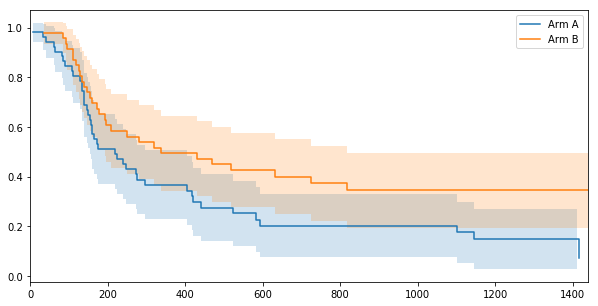

In [1029]:
plt.figure(figsize=(10,5))
plt.step(armA.t, armA.S_hat, label='Arm A', where='post')
plt.step(armB.t, armB.S_hat, label='Arm B', where='post')
plt.fill_between(armA.t, armA.S_hat + 1.96*armA.sd_S_hat, armA.S_hat - 1.96*armA.sd_S_hat, alpha=0.2, step='post')
plt.fill_between(armB.t, armB.S_hat + 1.96*armB.sd_S_hat, armB.S_hat - 1.96*armB.sd_S_hat, alpha=0.2, step='post')
plt.legend()
plt.xlim(0, 1440)

### Paramteric approach

$$
y_k \overset{ind}{\sim} Bi(n_k, h_k)\\
\mathbf{\lambda} = log\{ h_k/(1 - h_k) \}\\
\mathbf{\lambda} = \mathbf{X}\alpha
$$

**Using linear regression with cubics**

In [1030]:
def make_dmatrix(df):
    df['k'] = df['months']
    df['k2'] = df['k']**2
    df['k3'] = df['k']**3

    dmatrix = np.stack([np.ones_like(df['k']), df['k'], df['k2'], df['k3'] ], axis=1)
    
    # Normalize the features to avoid overflows
    dmatrix = (dmatrix - dmatrix.mean(axis=0))/dmatrix.std(axis=0)
    dmatrix[:,0]= 1

    n = df['n']
    y = df['y']
    
    return dmatrix, n, y

In [1031]:
dmatrix_A, n_A, y_A = make_dmatrix(armA_survival)
dmatrix_B, n_B, y_B = make_dmatrix(armB_survival)

In [1032]:
with pm.Model() as hazard_param:
    betas_A = pm.Normal('betas_A', 0, 10, shape=4)
    betas_B = pm.Normal('betas_B', 0, 10, shape=4)
    
    lambda_A = tt.dot(dmatrix_A, betas_A)
    h_A = pm.Deterministic('hA', pm.invlogit(lambda_A))
    yk_A = pm.Binomial('likeA', n_A, h_A, observed=y_A)
    
    lambda_B = tt.dot(dmatrix_B, betas_B)
    h_B = pm.Deterministic('hB', pm.invlogit(lambda_B))
    yk_B = pm.Binomial('likeB', n_B, h_B, observed=y_B)

In [1033]:
trace = pm.sample(tune=1000, draw=2000, model=hazard_param, chains=2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [betas_B, betas_A]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:18<00:00, 160.91draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


(0, 45)

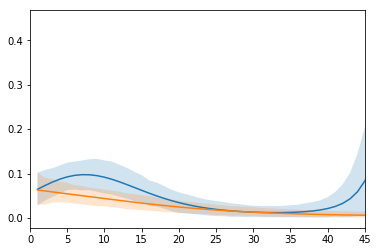

In [1034]:
summ_df = pm.summary(trace)
summ_hA = summ_df.filter(like="hA_", axis=0)
plt.plot(np.arange(1, len(summ_hA)+1), summ_hA['mean'], label='Arm A')
plt.fill_between(np.arange(1, len(summ_hA)+1), summ_hA['hpd_2.5'], summ_hA['hpd_97.5'], alpha=0.2)

summ_hB = summ_df.filter(like="hB_", axis=0)
plt.plot(np.arange(1, len(summ_hB)+1), summ_hB['mean'], label='Arm A')
plt.fill_between(np.arange(1, len(summ_hB)+1), summ_hB['hpd_2.5'], summ_hB['hpd_97.5'], alpha=0.2)

plt.xlim(0, 45)

**Using "cubic-linear splines" as per CASI**

In [1035]:
def make_spline_mat(df):
    df['k'] = df['months']
    df['k11_2'] = 0
    df['k11_3'] = 0
    df.loc[df.k <= 11, 'k11_2'] = (df.loc[df.k <= 11,'k'] - 11)**2
    df.loc[df.k <= 11, 'k11_3'] = (df.loc[df.k <= 11,'k'] - 11)**3

    dmatrix = np.stack([np.ones_like(df['k']), df['k'], df['k11_2'], df['k11_3']], axis=1)
    
    # Normalize the features to avoid overflows
    dmatrix = (dmatrix - dmatrix.mean(axis=0))/dmatrix.std(axis=0)
    dmatrix[:,0]= 1

    n = df['n']
    y = df['y']
    
    return dmatrix, n, y

In [1036]:
spline_matA, n_A, y_A = make_spline_mat(armA_survival)
spline_matB, n_B, y_B = make_spline_mat(armB_survival)

In [1037]:
with pm.Model() as hazard_param:
    betas_A = pm.Normal('betas_A', 0, 10, shape=4)
    betas_B = pm.Normal('betas_B', 0, 10, shape=4)
    
    lambda_A = tt.dot(spline_matA, betas_A)
    h_A = pm.Deterministic('hA', pm.invlogit(lambda_A))
    yk_A = pm.Binomial('likeA', n_A, h_A, observed=y_A)
    
    lambda_B = tt.dot(spline_matB, betas_B)
    h_B = pm.Deterministic('hB', pm.invlogit(lambda_B))
    yk_B = pm.Binomial('likeB', n_B, h_B, observed=y_B)

In [1038]:
trace = pm.sample(tune=1000, draw=2000, model=hazard_param, chains=2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [betas_B, betas_A]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 390.00draws/s]


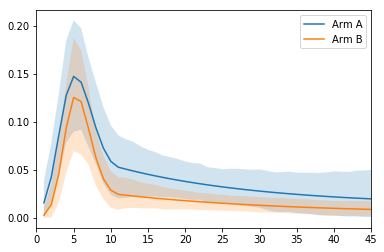

In [1039]:
summ_df = pm.summary(trace)

summ_hA = summ_df.filter(like="hA_", axis=0)
plt.plot(np.arange(1, len(summ_hA)+1), summ_hA['mean'], label='Arm A')
#plt.fill_between(np.arange(1, len(summ_hA)+1), summ_hA['mean'] + 1.96*summ_hA['sd'], summ_hA['mean'] - 1.96*summ_hA['sd'], alpha=0.2)        
plt.fill_between(np.arange(1, len(summ_hA)+1), summ_hA['hpd_2.5'], summ_hA['hpd_97.5'], alpha=0.2)

summ_hB = summ_df.filter(like="hB_", axis=0)
plt.plot(np.arange(1, len(summ_hB)+1), summ_hB['mean'], label='Arm B')
#plt.fill_between(np.arange(1, len(summ_hB)+1), summ_hB['mean'] + 1.96*summ_hB['sd'], summ_hB['mean'] - 1.96*summ_hB['sd'], alpha=0.2)
plt.fill_between(np.arange(1, len(summ_hB)+1), summ_hB['hpd_2.5'], summ_hB['hpd_97.5'], alpha=0.2)

plt.xlim(0, 45)
plt.legend()

This choice of 11 seems a little arbitrary. Let's try this again and allow for a switch parameter

In [704]:
with pm.Model() as hazard_param_switch:
    betas_A3 = pm.Normal('betas_A3', 0, 10, shape=4)
    betas_B3 = pm.Normal('betas_B3', 0, 10, shape=4)
 
    betas_A = pm.Normal('betas_A', 0, 10, shape=2)
    betas_B = pm.Normal('betas_B', 0, 10, shape=2)
    
    switchA = pm.Uniform('switchA', 0, 45)
    switchB = pm.Uniform('switchB', 0, 45)
    
    lambda_A = tt.switch(switchA, tt.dot(dmatrix_A, betas_A3), tt.dot(dmatrix_A[:,:2], betas_A))
    lambda_B = tt.switch(switchB, tt.dot(dmatrix_B, betas_B3), tt.dot(dmatrix_B[:,:2], betas_B))
    
    h_A = pm.Deterministic('hA', pm.invlogit(lambda_A))
    yk_A = pm.Binomial('likeA', n_A, h_A, observed=y_A)
    
    h_B = pm.Deterministic('hB', pm.invlogit(lambda_B))
    yk_B = pm.Binomial('likeB', n_B, h_B, observed=y_B)

In [705]:
trace = pm.sample(tune=1000, draw=2000, model=hazard_param_switch, chains=2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [switchB, switchA, betas_B, betas_A, betas_B3, betas_A3]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:27<00:00, 107.48draws/s]


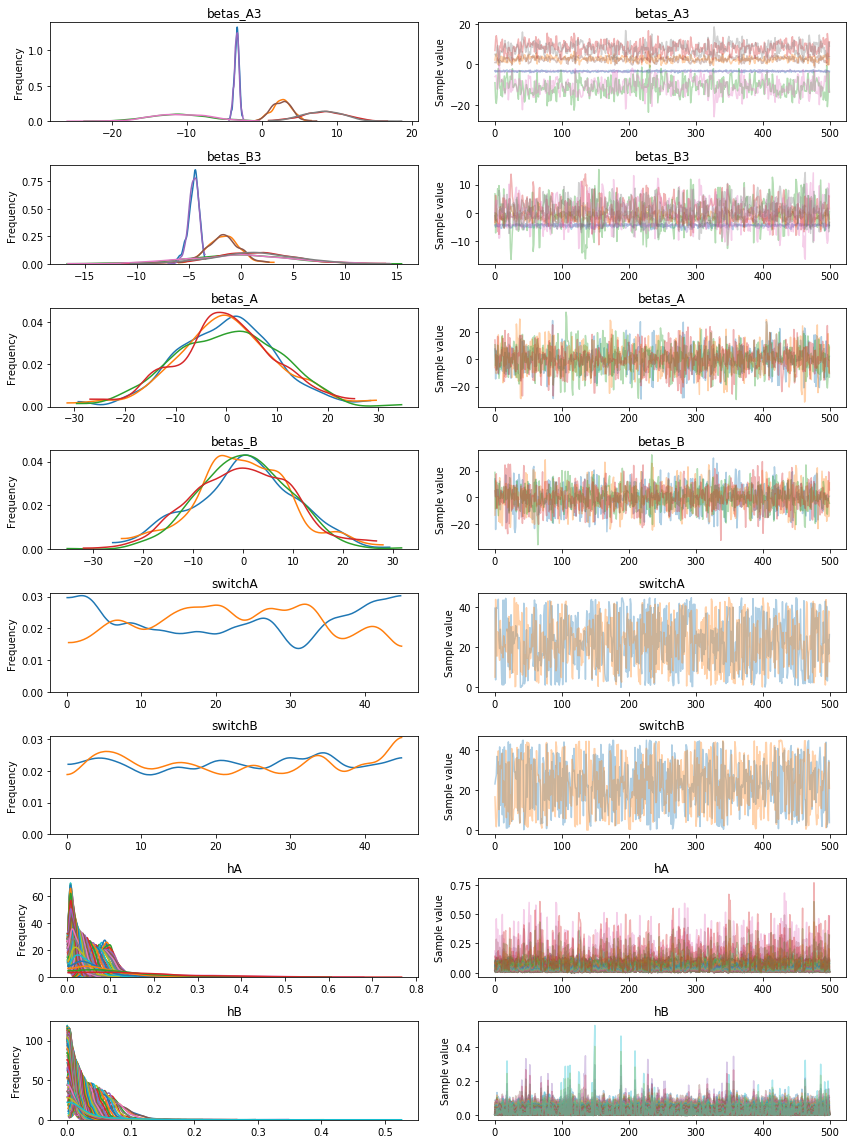

In [706]:
pm.traceplot(trace);

EEECCCCHHH! Those switches are poorly identified. The choice of 11 that Efron & Hastie choose is not revealed by my model.

### Gaussian Process

In [779]:
y_A.values.astype(int)

array([1, 2, 5, 2, 8, 7, 0, 3, 2, 2, 0, 0, 0, 3, 1, 0, 0, 1, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1])

In [1005]:
with pm.Model() as hazard_param_gp2:

    ro = pm.Exponential('ro', 1)
    eta = pm.Exponential('eta', 1)
    
    K = eta**2 * pm.gp.cov.ExpQuad(1, ro)
    gp = pm.gp.Latent(cov_func=K)
    
    latentA = gp.prior('latentA', X=armA_survival['k'].values.reshape(-1, 1))
    hA = pm.Deterministic('hA', pm.invlogit(latentA))

    latentB = gp.prior('latentB', X=armB_survival['k'].values.reshape(-1, 1))
    hB = pm.Deterministic('hB', pm.invlogit(latentB))
    
    likelihoodA = pm.Binomial('likeA', n=n_A.astype(int), p=hA, observed=y_A.values.astype(int))
    likelihoodB = pm.Binomial('likeB', n=n_B.astype(int), p=hB, observed=y_B.values.astype(int))
    

In [1006]:
trace = pm.sample(tune=1000, draw=2000, model=hazard_param_gp2, chains=2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [latentB_rotated_, latentA_rotated_, eta, ro]
Sampling 2 chains: 100%|██████████| 3000/3000 [02:27<00:00, 16.73draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


(0, 45)

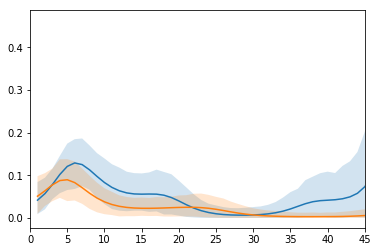

In [1009]:
summ_df = pm.summary(trace)
summ_hA = summ_df.filter(like="hA", axis=0)
plt.plot(np.arange(1, len(summ_hA)+1), summ_hA['mean'], label='Arm A')
plt.fill_between(np.arange(1, len(summ_hA)+1), summ_hA['hpd_2.5'], summ_hA['hpd_97.5'], alpha=0.2)

summ_hB = summ_df.filter(like="hB", axis=0)
plt.plot(np.arange(1, len(summ_hB)+1), summ_hB['mean'], label='Arm A')
plt.fill_between(np.arange(1, len(summ_hB)+1), summ_hB['hpd_2.5'], summ_hB['hpd_97.5'], alpha=0.2)

plt.xlim(0, 45)

## Section 9.3

In [1079]:
table94a = armA_survival.loc[:47, ['months','n','y']].copy()
table94a.columns = ['month','at_risk', 'dead']

In [1080]:
table94b = armB_survival.loc[:47, ['months','n','y']].copy()
table94b.columns = ['month','at_risk', 'dead']

In [1081]:
table94 = table94a.merge(table94b, left_index=True, right_index=True, suffixes= ("_A", "_B"))
table94['n_d'] = table94['dead_A'] + table94['dead_B']
table94['n'] = table94['at_risk_A'] + table94['at_risk_B'] 
table94['n_s'] = table94['n'] - table94['n_d']

In [1087]:
table94['E'] = table94['n_d']*table94['at_risk_A']/table94['n']
table94['V'] = table94['n_d']*table94['at_risk_A']*table94['at_risk_B']*table94['n_s']/((table94['n']**2)*(table94['n']-1))

In [1153]:
table94.head()

,month_A,at_risk_A,dead_A,month_B,at_risk_B,dead_B,n_d,n,n_s,E,V
0,1,51.0,1.0,1,45.0,0.0,1.0,96.0,95.0,0.531250,0.249023
1,2,50.0,2.0,2,45.0,1.0,3.0,95.0,92.0,1.578947,0.732009
2,3,48.0,5.0,3,44.0,1.0,6.0,92.0,86.0,3.130435,1.414903
3,4,42.0,2.0,4,43.0,5.0,7.0,85.0,78.0,3.458824,1.624775
4,5,40.0,8.0,5,38.0,5.0,13.0,78.0,65.0,6.666667,2.741703


Values for V[5] according to the book is 2.28 (looks like they did N^3 in the denominator), here we get 2.32.

In [1090]:
Z = (table94.dead_A - table94.E).sum() / (table94.V.sum()**(1/2))
Z

2.2859374180594703

## Section 9.4

In [173]:
import statsmodels.api as sm

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [174]:
df = pd.read_csv("https://web.stanford.edu/~hastie/CASI_files/DATA/pediatric.txt", sep=" ").sort_values('t')

In [175]:
df.head()

,sex,race,age,entry,far,t,d
746,2,1,11.58,186,65,118,0
840,1,1,0.67,721,23,119,0
74,2,1,16.00,1227,60,125,0
1483,1,2,3.17,1982,47,125,1
940,2,1,5.67,2254,88,125,1


In [176]:
df_byt = df.groupby('t')[['d']].agg([sum, 'count']).reset_index()
df_byt.columns = ['t','deaths','count']
df_byt['at_risk'] = df_byt['count'].sum() - (df_byt['count'].cumsum().shift(1).fillna(0.0))#['at_risk'] = df_byt
df_byt['lost'] = df_byt['count'] - df_byt['deaths']
#df_byt = df_byt[df_byt.deaths > 0]
df_byt['t_1'] = df_byt['t'].shift(1)
df_byt['del_t'] = (df_byt['t'] - df_byt['t_1']).fillna(1.0)

In [177]:
df_byt['h_t'] = df_byt['deaths'] / (df_byt['at_risk'] * df_byt['del_t'])

In [178]:
df_byt.head()

,t,deaths,count,at_risk,lost,t_1,del_t,h_t
0,118,0,1,1620.0,1,NaN,1.0,0.000000
1,119,0,1,1619.0,1,118.0,1.0,0.000000
2,125,16,23,1618.0,7,119.0,6.0,0.001648
3,126,2,18,1595.0,16,125.0,1.0,0.001254
4,127,0,6,1577.0,6,126.0,1.0,0.000000


In [179]:
df_byt['surv_func'] = (1 - df_byt['h_t']).cumprod()

In [316]:
df2 = df.merge(df_byt, left_on='t', right_on='t', how='left')
df2['log_h'] = df2['h_t'].apply(np.log)
#df2 = df2[df2.h_t > 0]

# standardize vars
for var in ['age','entry','far']:
    df2[var] = (df2[var] - df2[var].mean())/ df2[var].std()


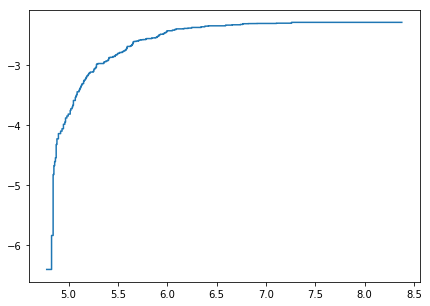

In [317]:
plt.figure(figsize=(7,5))
plt.step(df_byt.t.apply(np.log), (df_byt.surv_func.apply(np.log)*-1).apply(np.log), )

In [318]:
Xt = df2.loc[:, ['t','sex','race','age','entry','far','d']]
X = df2.loc[:, ['sex','race','age','entry','far']]
censored = (df2.d == 1).values 
X.head()

Xmat= df2.loc[:, ['sex','race','age','entry','far']].values
y = df2.loc[:, 't']


$$
U_k(\beta)=\dfrac{\partial{}_{p}\ell_k(\beta)}{\partial\beta_k}=\sum\limits_{i=1}^{K}\Big(X_{ik}-A_{ik}\Big)
$$
where:
$$
\begin{equation}
A_{ik} = \dfrac{\sum\limits_{l\in \mathscr{R}(t_i)}^{} X_{lk} e^{X_l'\beta}}{\sum\limits_{l\in \mathscr{R}(t_i)}^{} e^{X_l'\beta}}
\end{equation}
$$



### Using statsmodels

In [324]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [328]:
mod = smf.phreg("t ~ sex + race + age + entry + far",
                subt_df, status=subt_df['d'], ties="efron")
rslt = mod.fit()
print(rslt.summary())

                      Results: PHReg
Model:                     PH Reg      Sample size:      47
Dependent variable:        t           Num. events:      18
Ties:                      Efron                           
-----------------------------------------------------------
       log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-----------------------------------------------------------
sex    0.5875    0.5351 1.7994  1.0979 0.2723 0.6305 5.1359
race  -0.0379    0.5614 0.9628 -0.0675 0.9462 0.3204 2.8936
age   -0.4086    0.2863 0.6646 -1.4273 0.1535 0.3792 1.1647
entry  0.4067    0.2825 1.5019  1.4398 0.1499 0.8634 2.6128
far   -0.1132    0.2990 0.8930 -0.3784 0.7051 0.4970 1.6047
Confidence intervals are for the hazard ratios


### Doing it from scratch

http://soep.ue.poznan.pl/jdownloads/Wszystkie%20numery/Rok%202014/06_borucka.pdf

Since there are ties we need to use an approximation method that handles it. Using Efron approximation.

$$
L_j^{Efron} = \frac{\prod_{i \in D_j} exp\{\beta^Tx_i\}}
                   {\prod_{h=1}^{d_j}\left\{\sum_{i \in R_j}exp\{\beta^TX_i\} - \frac{h - 1}{d_j}\sum_{k \in D_j} exp\{\beta^Tx_k\}\right\}}
$$

#### Define log-likelihood function

In [574]:
from scipy.special import logsumexp
def get_efron_ll(X, beta, T, E, weights):
    
    phi = dot(X, beta)
    exp_phi = exp(phi)
    log_lik = 0
    risk_exp_phi = 0

    unique_t = np.flip(np.unique(T), axis=0)

    for t_i in unique_t:
        tie_ids = np.where(T == t_i)
        events = E[tie_ids]
        n_ties = events.sum()

        risk_exp_phi += exp_phi[tie_ids].sum()

        if events.sum() > 0:

            phi_ties = (phi[tie_ids] * events)
            exp_phi_ties = (exp_phi[tie_ids] * events)

            # numerator
            numerator = phi_ties.sum()

            # denominator
            denominator = 0
            for h in range(n_ties):
                denominator += np.log(risk_exp_phi - (h/n_ties)*(exp_phi_ties.sum()))
            log_lik += (numerator - denominator)

    return log_lik

#### Define a custome likelihoos model in statsmodels

In [577]:
from statsmodels.base.model import GenericLikelihoodModel

In [578]:
class PHCox(GenericLikelihoodModel):
    def __init__(self, endog, exog, censored, event_time, **kwds):
        super(PHCox, self).__init__(endog, exog, **kwds)
        self.censored = censored
        self.event_time = event_time
        
    def nloglikeobs(self, params):
        weights = np.ones_like(self.event_time)
        ll= get_efron_ll(self.exog, params, self.event_time, self.censored, weights)
        return -ll 
    
    def fit(self, start_params=[], maxiter=10000, maxfun=5000, **kwds):
        if len(start_params) == 0:
            # Reasonable starting values
            start_params = np.zeros(self.exog.shape[1])
        return super(PHCox, self).fit(start_params=start_params, 
                                     maxiter=maxiter, maxfun=maxfun, 
                                     **kwds) 

In [579]:
m = PHCox(y, X, E, T).fit()

Optimization terminated successfully.
         Current function value: 0.697309
         Iterations: 548
         Function evaluations: 893


In [580]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                PHCox Results                                 
==============================================================================
Dep. Variable:                      t   Log-Likelihood:                -1129.6
Model:                          PHCox   AIC:                             2269.
Method:            Maximum Likelihood   BIC:                             2296.
Date:                Tue, 04 Sep 2018                                         
Time:                        12:54:33                                         
No. Observations:                1620                                         
Df Residuals:                    1615                                         
Df Model:                           4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex           -0.0231      0.160     -0.144      0.886      -0.338       0.291
race           0.2823      0.169      1.671      0.095      -0.049       0.613
age           -0.2350      0.088     -2.664      0.008      -0.408      -0.062
entry         -0.4598      0.079     -5.856      0.000      -0.614      -0.306
far            0.2958      0.072      4.120      0.000       0.155       0.436
==============================================================================
"""

## Section 9.5

In [149]:
# Generate some data

mu1 = 2
mu2 = 1
sig1 = 1
sig2 = 0.5
ro = 0.8

n_points = 40 

np.random.seed(50)

points = np.random.multivariate_normal([mu1, mu2], np.array([[sig1**2, sig1*sig2*ro],
                                                             [sig1*sig2*ro, sig2**2]]), n_points)

censored_pts = points.copy()
censored_pts[-20:,1] = 0

### Figure 9.3

Text(0.5,1,'Censored')

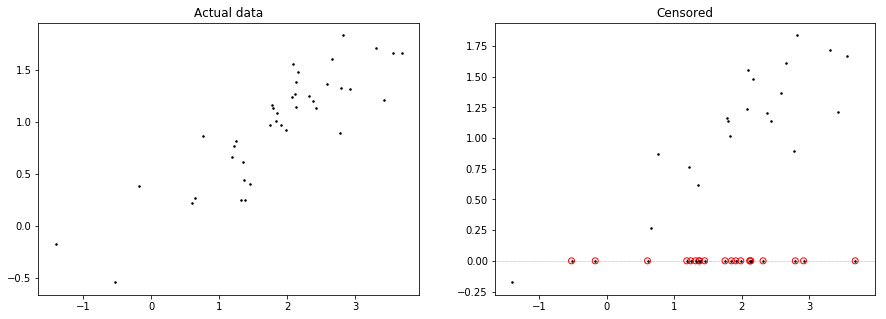

In [150]:
plt.figure(figsize=(15,5))
ax = plt.subplot(121)
ax.plot(points[:,0], points[:,1], ".k", ms=3)
ax.set_title("Actual data")

ax = plt.subplot(122)
ax.plot(censored_pts[:,0], censored_pts[:,1], ".k", ms=3)
ax.axhline(y=0, lw=0.5, ls=":")
ax.scatter(censored_pts[-20:,0], censored_pts[-20:,1], facecolors='none', edgecolors='r')
ax.set_title("Censored")

In [151]:
def em_step(censored_pts):
    n_points = len(censored_pts)
    x1 = censored_pts[:,0]
    x2 = censored_pts[:,1]
    
    mu1 = x1.sum() / n_points
    mu2 = x2.sum() / n_points
    
    sig1 = ((((x1 - mu1)**2)/n_points).sum())**(1/2)
    sig2 = ((((x2 - mu2)**2)/n_points).sum())**(1/2)
    
    ro = ((x1 - mu1)*(x2 - mu2)/n_points).sum() / (sig1*sig2)
    
    return mu1, mu2, sig1, sig2, ro

In [152]:
def ee_step(censored_pts, mu1, mu2, sig1, sig2, ro):
    
    censored_pts[-20:,1] = mu2 + ro * (sig2/sig1) * (censored_pts[-20:,0] - mu1)
    
    return censored_pts

### Run the EM algorithm

In [166]:
estimated_pts = censored_pts.copy()
all_estimates = []
max_iters = 1000
prev_params = np.zeros(5)
epsilon = 1e-4

for i in range(max_iters):
    params = em_step(estimated_pts)

    if (np.abs(prev_params - np.array(params)).sum()) < epsilon:
        break
        
    all_estimates.append(list(params))
    estimated_pts = ee_step(estimated_pts, *params)
    
    prev_params = params

params, i

((1.8402221079323504,
  1.0649133190511066,
  1.0490441272255142,
  0.4315835291047046,
  0.9127749689310635),
 15)

In [167]:
pd.DataFrame(all_estimates, columns =['mu1', 'mu2', 'sig1', 'sig2', 'ro'])

,mu1,mu2,sig1,sig2,ro
0,1.840222,0.564464,1.049044,0.660733,0.472514
1,1.840222,0.821344,1.049044,0.502878,0.794759
2,1.840222,0.942683,1.049044,0.467683,0.889812
3,1.840222,1.002014,1.049044,0.453554,0.911324
4,1.840222,1.031908,1.049044,0.445029,0.915255
5,1.840222,1.047344,1.049044,0.439602,0.915186
6,1.840222,1.055468,1.049044,0.436252,0.914448
7,1.840222,1.059805,1.049044,0.434252,0.913811
8,1.840222,1.062144,1.049044,0.433086,0.913382
9,1.840222,1.063415,1.049044,0.432418,0.913119


(0, 2)

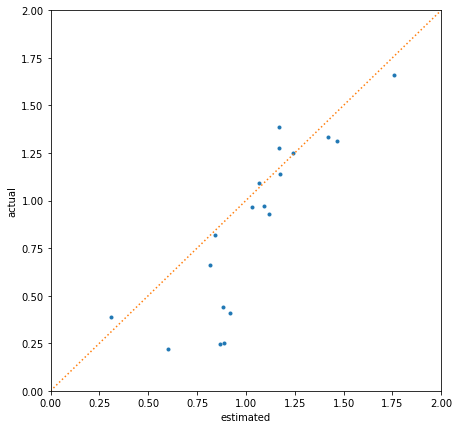

In [169]:
plt.figure(figsize=(7,7))

plt.plot(estimated_pts[-20:,1], points[-20:,1], ".")
plt.plot([0,2],[0,2], ls=":")
plt.xlabel("estimated")
plt.ylabel("actual")
plt.xlim(0, 2)
plt.ylim(0, 2)